## NLP for Task Classification

**Hypothesis**: Part of Speech (POS) tagging and syntactic dependency parsing provides valuable information for classifying imperative phrases. The thinking is that being able to detect imperative phrases will transfer well to detecting tasks and to-dos.

#### Some Terminology
- [_Imperative mood_](https://en.wikipedia.org/wiki/Imperative_mood) is "used principally for ordering, requesting or advising the listener to do (or not to do) something... also often used for giving instructions as to how to perform a task."
- _Part of speech (POS)_ is a way of categorizing a word based on its syntactic function.
    - The POS tagger from Spacy.io that is used in this notebook differentiates between [*pos_* and *tag_*](https://spacy.io/docs/api/annotation#pos-tagging-english) - *POS (pos_)* refers to "coarse-grained part-of-speech" like `VERB`, `ADJ`, or `PUNCT`; and *POSTAG (tag_)* refers to "fine-grained part-of-speech" like `VB`, `JJ`, or `.`.
- _Syntactic dependency parsing_ is a way of connecting words based on syntactic relationships, [such as](https://spacy.io/docs/api/annotation#dependency-parsing-english) `DOBJ` (direct object), `PREP` (prepositional modifier), or `POBJ` (object of preposition).
    - Check out the dependency parse of the phrase ["Send the report to Kyle by tomorrow"](https://demos.explosion.ai/displacy/?text=Send%20the%20report%20to%20Kyle%20by%20tomorrow&model=en&cpu=1&cph=1) as an example.

### Proposed Features
The imperative mood centers around _actions_, and actions are generally represented in English using verbs. So the features are engineered to also center on the VERB:
1. `FeatureName.VERB`: Does the phrase contain `VERB`(s) of the tag form `VB*`?
2. `FeatureName.FOLLOWING_POS`: Are the words following the `VERB`(s) of certain parts of speech?
3. `FeatureName.FOLLOWING_POSTAG`: Are the words following the `VERB`(s) of certain POS tags?
4. `FeatureName.CHILD_DEP`: Are the `VERB`(s) parents of certain syntactic dependencies?
5. `FeatureName.PARENT_DEP`: Are the `VERB`(s) children of certain syntactic dependencies?
6. `FeatureName.CHILD_POS`: Are the syntactic dependencies that the `VERB`(s) are children of of certain parts of speech?
7. `FeatureName.CHILD_POSTAG`: Are the syntactic dependencies that the `VERB`(s) are children of of certain POS tags?
8. `FeatureName.PARENT_POS`: Are the syntactic dependencies that the `VERB`(s) parent of certain parts of speech?
9. `FeatureName.PARENT_POSTAG`: Are the syntactic dependencies that the `VERB`(s) parent of certain POS tags?

**Notes:**
- Features 2-9 all depend on feature 1 between `True`; if `False`, phrase vectorization will result in all zeroes.
- When features 2-9 are applied to actual phrases, they will append identifying informating about the feature in the form of `_*` (e.g., `FeatureName.FOLLOWING_POSTAG_WRB`).

## Data and Setup

### Building a recipe corpus

I wrote and ran `epicurious_recipes.py`\* to scrape Epicurious.com for recipe instructions and descriptions. I then performed some manual cleanup of the script results. Output is in `epicurious-pos.txt` and `epicurious-neg.txt`.

\* _script (very) loosely based off of https://github.com/benosment/hrecipe-parse_

**Note** that deriving all negative examples in the training set from Epicurious recipe descriptions would result in negative examples that are longer and syntactically more complicated than the positive examples. This is a form of bias.

To (hopefully?) correct for this a bit, I will add the short movie reviews found at https://pythonprogramming.net/static/downloads/short_reviews/ as more negative examples.

This still feels weird because we're selecting negative examples only from specific categories of text (recipe descriptions, short movie reviews) - just because they're readily available. Further, most positive examples are recipe instructions - also a specific (and not necessarily related to the main "task" category) category of text.

Ultimately though, this recipe corpus is a **stopgap/proof of concept** for a corpus more relevant to tasks later on, so I won't worry further about this for now.

In [1]:
import os
from pandas import read_csv
from numpy import random

In [2]:
BASE_DIR = os.getcwd()
data_path = BASE_DIR + '/data.tsv'

In [3]:
df = read_csv(data_path, sep='\t', header=None, names=['Text', 'Label'])
df.head()

,Text,Label
0,Be kind,pos
1,Get out of here,pos
2,Look this over,pos
3,"Paul, do your homework now",pos
4,Do not clean soot off the window,pos


In [4]:
pos_data_split = list(df.loc[df.Label == 'pos'].Text)
neg_data_split = list(df.loc[df.Label == 'neg'].Text)

num_pos = len(pos_data_split)
num_neg = len(neg_data_split)

# 50/50 split between the number of positive and negative samples
num_per_class = num_pos if num_pos < num_neg else num_neg

# shuffle samples
random.shuffle(pos_data_split)
random.shuffle(neg_data_split)

In [5]:
lines = []
for l in pos_data_split[:num_per_class]:
    lines.append((l, 'pos'))
for l in neg_data_split[:num_per_class]:
    lines.append((l, 'neg'))

In [6]:
# Features as defined in the introduction
from enum import Enum, auto
class FeatureName(Enum):
    VERB = auto()
    FOLLOWING_POS = auto()
    FOLLOWING_POSTAG = auto()
    CHILD_DEP = auto()
    PARENT_DEP = auto()
    CHILD_POS = auto()
    CHILD_POSTAG = auto()
    PARENT_POS = auto()
    PARENT_POSTAG = auto()

## [spaCy.io](https://spacy.io/) for NLP
_Because Stanford CoreNLP is hard to install for Python_

Found Spacy through an article on ["Training a Classifier for Relation Extraction from Medical Literature"](https://www.microsoft.com/developerblog/2016/09/13/training-a-classifier-for-relation-extraction-from-medical-literature/) ([GitHub](https://github.com/CatalystCode/corpus-to-graph-ml))

<img src="nltk_library_comparison.png" alt="NLTK library comparison chart https://spacy.io/docs/api/#comparison" style="width: 400px; margin: 0;"/>

In [7]:
#!conda config --add channels conda-forge
#!conda install spacy
#!python -m spacy download en

### Using the Spacy Data Model for NLP

In [8]:
import spacy
nlp = spacy.load('en')

Spacy's sentence segmentation is lacking... https://github.com/explosion/spaCy/issues/235. So each '\n' will start a new Spacy Doc.

In [9]:
def create_spacy_docs(ll):
    dd = [(nlp(l[0]), l[1]) for l in ll]
    # collapse noun phrases into single compounds
    for d in dd:
        for np in d[0].noun_chunks:
            np.merge(np.root.tag_, np.text, np.root.ent_type_)
    return dd

In [10]:
docs = create_spacy_docs(lines)

### NLP output

Tokenization, POS tagging, and dependency parsing happened automatically with the `nlp(line)` calls above! So let's look at the outputs.

https://spacy.io/docs/usage/data-model and https://spacy.io/docs/api/doc will be useful going forward

In [11]:
for doc in docs[:10]:
    print(list(doc[0].sents))

[Spread on a rimmed baking sheet and roast until an instant-read thermometer inserted into thickest part of thigh registers 165°F, 15–17 minutes.]
[Thread 2 pieces of chicken onto each skewer.]
[Peel off the top layer of cling film then invert the pastry circle into the prepared tart tin, gently pressing it into all the edges.]
[Remove the thin clear sliver of cartilage; discard.]
[Butter a 9x9-inch cake pan.]
[Serve with a crunchy green salad.]
[Let steep 4 minutes. Discard tea bags and let cool slightly (you should have about 3 1/2 cups tea).]
[Serve with sauces alongside, if desired.]
[Transfer chickens to a cutting board and let rest at least 10 minutes before carving.]
[Blend lemonade ice cubes, 1/2 cup vodka, and 1/2 cup lemonade in a blender until smooth.]


In [12]:
for doc in docs[:10]:
    print(list(doc[0].noun_chunks))

[a rimmed baking sheet, roast, an instant-read thermometer, thickest part, thigh registers]
[Thread 2 pieces, chicken, each skewer]
[Peel, the top layer, film, the pastry circle, the prepared tart tin, it, all the edges]
[the thin clear sliver, cartilage]
[a 9x9-inch cake pan]
[a crunchy green salad]
[tea bags, you, about 3 1/2 cups tea]
[sauces]
[Transfer chickens, a cutting board]
[lemonade ice cubes, 1/2 cup vodka, 1/2 cup lemonade, a blender]


[Spacy's dependency graph visualization](https://demos.explosion.ai/displacy)

In [13]:
for doc in docs[:5]:
    for token in doc[0]:
        print(token.text, token.dep_, token.lemma_, token.pos_, token.tag_, token.head, list(token.children))

Spread ROOT spread VERB VB Spread [on, until, .]
on prep on ADP IN Spread [a rimmed baking sheet]
a rimmed baking sheet pobj a rimmed baking sheet NOUN NN on [and, roast]
and cc and CCONJ CC a rimmed baking sheet []
roast conj roast NOUN NN a rimmed baking sheet []
until prep until ADP IN Spread [an instant-read thermometer]
an instant-read thermometer pobj an instant-read thermometer NOUN NN until [inserted]
inserted acl insert VERB VBN an instant-read thermometer [into, minutes]
into prep into ADP IN inserted [thickest part]
thickest part pobj thickest part NOUN NN into [of]
of prep of ADP IN thickest part [thigh registers]
thigh registers pobj thigh registers NOUN NNS of [165°F]
165°F appos 165°f NUM CD thigh registers [,]
, punct , PUNCT , 165°F []
15–17 nummod 15–17 NUM CD minutes []
minutes npadvmod minute NOUN NNS inserted [15–17]
. punct . PUNCT . Spread []
Thread 2 pieces ROOT Thread 2 pieces NOUN NNS Thread 2 pieces [of, onto, .]
of prep of ADP IN Thread 2 pieces [chicken]
ch

### Featurization

In [14]:
import re
from collections import defaultdict

def featurize(d):
    s_features = defaultdict(int)
    for idx, token in enumerate(d):
        if re.match(r'VB.?', token.tag_) is not None: # note: not using token.pos == VERB because this also includes BES, HVS, MD tags 
            s_features[FeatureName.VERB.name] += 1
            # FOLLOWING_POS
            # FOLLOWING_POSTAG
            next_idx = idx + 1;
            if next_idx < len(d):
                s_features[f'{FeatureName.FOLLOWING_POS.name}_{d[next_idx].pos_}'] += 1
                s_features[f'{FeatureName.FOLLOWING_POSTAG.name}_{d[next_idx].tag_}'] += 1
            # PARENT_DEP
            # PARENT_POS
            # PARENT_POSTAG
            '''
            "Because the syntactic relations form a tree, every word has exactly one head.
            You can therefore iterate over the arcs in the tree by iterating over the words in the sentence."
            https://spacy.io/docs/usage/dependency-parse#navigating
            '''
            if (token.head is not token):
                s_features[f'{FeatureName.PARENT_DEP.name}_{token.head.dep_.upper()}'] += 1
                s_features[f'{FeatureName.PARENT_POS.name}_{token.head.pos_}'] += 1
                s_features[f'{FeatureName.PARENT_POSTAG.name}_{token.head.tag_}'] += 1
            # CHILD_DEP
            # CHILD_POS
            # CHILD_POSTAG
            for child in token.children:
                s_features[f'{FeatureName.CHILD_DEP.name}_{child.dep_.upper()}'] += 1
                s_features[f'{FeatureName.CHILD_POS.name}_{child.pos_}'] += 1
                s_features[f'{FeatureName.CHILD_POSTAG.name}_{child.tag_}'] += 1
    return dict(s_features)

In [15]:
featuresets = [(doc[0], (featurize(doc[0]), doc[1])) for doc in docs]

In [16]:
from statistics import mean, median, mode, stdev
f_lengths = [len(fs[1][0]) for fs in featuresets]

print('Stats on number of features per example:')
print(f'mean: {mean(f_lengths)}')
print(f'stdev: {stdev(f_lengths)}')
print(f'median: {median(f_lengths)}')
print(f'mode: {mode(f_lengths)}')
print(f'max: {max(f_lengths)}')
print(f'min: {min(f_lengths)}')

Stats on number of features per example:
mean: 23.039031836022676
stdev: 14.543193390809183
median: 23.0
mode: 0
max: 75
min: 0


In [17]:
featuresets[:2]

[(Spread on a rimmed baking sheet and roast until an instant-read thermometer inserted into thickest part of thigh registers 165°F, 15–17 minutes.,
  ({'CHILD_DEP_NPADVMOD': 1,
    'CHILD_DEP_PREP': 3,
    'CHILD_DEP_PUNCT': 1,
    'CHILD_POSTAG_.': 1,
    'CHILD_POSTAG_IN': 3,
    'CHILD_POSTAG_NNS': 1,
    'CHILD_POS_ADP': 3,
    'CHILD_POS_NOUN': 1,
    'CHILD_POS_PUNCT': 1,
    'FOLLOWING_POSTAG_IN': 2,
    'FOLLOWING_POS_ADP': 2,
    'PARENT_DEP_POBJ': 1,
    'PARENT_POSTAG_NN': 1,
    'PARENT_POS_NOUN': 1,
    'VERB': 2},
   'pos')),
 (Thread 2 pieces of chicken onto each skewer., ({}, 'pos'))]

On one run, the above line printed the following featureset:
`(Gather foil loosely on top and bake for 1 1/2 hours., ({}, 'pos'))`

This is because the Spacy.io POS tagger provided this:
   `Gather/NNP foil/NN loosely/RB on/IN top/NN and/CC bake/NN for/IN 1 1/2 hours./NNS`

...with no VERBs tagged, which is incorrect.

"Voting - POS taggers and classifiers" in the _Next Steps/Improvements_ section below is meant to improve on this.

---
Compare to [Stanford CoreNLP POS tagger](http://nlp.stanford.edu:8080/corenlp/process):
   `Gather/VB foil/NN loosely/RB on/IN top/JJ and/CC bake/VB for/IN 1 1/2/CD hours/NNS ./.`

And [Stanford Parser](http://nlp.stanford.edu:8080/parser/index.jsp):
   `Gather/NNP foil/VB loosely/RB on/IN top/NN and/CC bake/VB for/IN 1 1/2/CD hours/NNS ./.`

### Classification

In [18]:
random.shuffle(featuresets)

num_classes = 2
split_num = round(num_per_class*num_classes / 5)

# train and test sets
testing_set = [fs[1] for i, fs in enumerate(featuresets[:split_num])]
training_set =  [fs[1] for i, fs in enumerate(featuresets[split_num:])]

print(f'# training samples: {len(training_set)}')
print(f'# test samples: {len(testing_set)}')

# training samples: 3669
# test samples: 917


In [19]:
# decoupling the functionality of nltk.classify.accuracy
def predict(classifier, gold, prob=True):
    if (prob is True):
        predictions = classifier.prob_classify_many([fs for (fs, ll) in gold])
    else:
        predictions = classifier.classify_many([fs for (fs, ll) in gold])
    return list(zip(predictions, [ll for (fs, ll) in gold]))

def accuracy(predicts, prob=True):
    if (prob is True):
        correct = [label == prediction.max() for (prediction, label) in predicts]
    else:
        correct = [label == prediction for (prediction, label) in predicts]
        
    if correct:
        return sum(correct) / len(correct)
    else:
        return 0

Note below the use of `DummyClassifier` to provide a simple sanity check, a baseline of random predictions. `stratified` means it "generates random predictions by respecting the training set class distribution." (http://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators)

> More generally, when the accuracy of a classifier is too close to random, it probably means that something went wrong: features are not helpful, a hyperparameter is not correctly tuned, the classifier is suffering from class imbalance, etc…

If a classifier can beat the `DummyClassifier`, it is at least learning something valuable! How valuable is another question...

In [20]:
from nltk import NaiveBayesClassifier
from nltk.classify.decisiontree import DecisionTreeClassifier
from nltk.classify.scikitlearn import SklearnClassifier

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

dummy = SklearnClassifier(DummyClassifier(strategy='stratified', random_state=0))
dummy.train(training_set)
dummy_predict = predict(dummy, testing_set)
dummy_accuracy = accuracy(dummy_predict)
print("Dummy classifier accuracy percent:", dummy_accuracy*100)

nb = NaiveBayesClassifier.train(training_set)
nb_predict = predict(nb, testing_set)
nb_accuracy = accuracy(nb_predict)
print("NaiveBayes classifier accuracy percent:", nb_accuracy*100)

multinomial_nb = SklearnClassifier(MultinomialNB())
multinomial_nb.train(training_set)
mnb_predict = predict(multinomial_nb, testing_set)
mnb_accuracy = accuracy(mnb_predict)
print("MultinomialNB classifier accuracy percent:", mnb_accuracy*100)

bernoulli_nb = SklearnClassifier(BernoulliNB())
bernoulli_nb.train(training_set)
bnb_predict = predict(bernoulli_nb, testing_set)
bnb_accuracy = accuracy(bnb_predict)
print("BernoulliNB classifier accuracy percent:", bnb_accuracy*100)

# ??logistic_regression._clf
#   sklearn.svm.LinearSVC : learns SVM models using the same algorithm.
logistic_regression = SklearnClassifier(LogisticRegression())
logistic_regression.train(training_set)
lr_predict = predict(logistic_regression, testing_set)
lr_accuracy = accuracy(lr_predict)
print("LogisticRegression classifier accuracy percent:", lr_accuracy*100)

# ??sgd._clf
#    The 'log' loss gives logistic regression, a probabilistic classifier.
# ??linear_svc._clf
#   can optimize the same cost function as LinearSVC
#   by adjusting the penalty and loss parameters. In addition it requires
#   less memory, allows incremental (online) learning, and implements
#   various loss functions and regularization regimes.
sgd = SklearnClassifier(SGDClassifier(loss='log'))
sgd.train(training_set)
sgd_predict = predict(sgd, testing_set)
sgd_accuracy = accuracy(sgd_predict)
print("SGD classifier accuracy percent:", sgd_accuracy*100)

# slow
# using libsvm with kernel 'rbf' (radial basis function)
svc = SklearnClassifier(SVC(probability=True))
svc.train(training_set)
svc_predict = predict(svc, testing_set)
svc_accuracy = accuracy(svc_predict)
print("SVC classifier accuracy percent:", svc_accuracy*100)

# ??linear_svc._clf
#    Similar to SVC with parameter kernel='linear', but implemented in terms of
#    liblinear rather than libsvm, so it has more flexibility in the choice of
#    penalties and loss functions and should scale better to large numbers of
#    samples.
#    Prefer dual=False when n_samples > n_features.
# Using CalibratedClassifierCV as wrapper to get predict probabilities (https://stackoverflow.com/a/39712590)
linear_svc = SklearnClassifier(CalibratedClassifierCV(LinearSVC(dual=False)))
linear_svc.train(training_set)
linear_svc_predict = predict(linear_svc, testing_set)
linear_svc_accuracy = accuracy(linear_svc_predict)
print("LinearSVC classifier accuracy percent:", linear_svc_accuracy*100)

# slower
dt = DecisionTreeClassifier.train(training_set)
dt_predict = predict(dt, testing_set, False)
dt_accuracy = accuracy(dt_predict, False)
print("DecisionTree classifier accuracy percent:", dt_accuracy*100)

random_forest = SklearnClassifier(RandomForestClassifier(n_estimators = 100))
random_forest.train(training_set)
rf_predict = predict(random_forest, testing_set)
rf_accuracy = accuracy(rf_predict)
print("RandomForest classifier accuracy percent:", rf_accuracy*100)

Dummy classifier accuracy percent: 50.4907306434024
NaiveBayes classifier accuracy percent: 67.2846237731734
MultinomialNB classifier accuracy percent: 79.93456924754635
BernoulliNB classifier accuracy percent: 73.93675027262813
LogisticRegression classifier accuracy percent: 83.75136314067612
SGD classifier accuracy percent: 77.09923664122137
SVC classifier accuracy percent: 81.02508178844057
LinearSVC classifier accuracy percent: 83.6423118865867
DecisionTree classifier accuracy percent: 77.09923664122137
RandomForest classifier accuracy percent: 82.33369683751364


### SGD: Multiple Epochs

`sgd` classifiers improves with epochs. `??sgd._clf` tells us that the default number of epochs `n_iter` is 5. So let's run more epochs. Also not that the training_set shuffle is `True` by default.

In [21]:
num_epochs = 1000
sgd = SklearnClassifier(SGDClassifier(loss='log', n_iter=num_epochs))
sgd.train(training_set)
sgd_predict = predict(sgd, testing_set)
sgd_accuracy = accuracy(sgd_predict)
print(f"SGDClassifier classifier accuracy percent (epochs: {num_epochs}):", sgd_accuracy*100)

SGDClassifier classifier accuracy percent (epochs: 1000): 83.53326063249727


Fortunately, 1000 epochs run very quickly! And `SGDClassifier` performance has improved with more iterations.

*Also note that we can set `warm_start` to `True` if we want to take advantage of online learning and reuse the solution of the previous call.*

### VotingClassifier

We're going to create an ensemble classifier by letting our top-performing classifiers, which consistently perform with >80% accuracy &mdash; LogisticRegression, SVC, LinearSVC, SGD, and RandomForest &mdash; vote on each prediction.

In [22]:
from sklearn.ensemble import VotingClassifier

voting = SklearnClassifier(VotingClassifier(estimators=[
    ('lr', logistic_regression._clf),
    ('linear_svc', linear_svc._clf),
    ('sgd', sgd._clf),
    ('rf', random_forest._clf)
], voting='soft', n_jobs=-1))
voting.train(training_set)
voting_predict = predict(voting, testing_set)
voting_accuracy = accuracy(voting_predict)
print("Soft voting classifier accuracy percent:", voting_accuracy*100)

Soft voting classifier accuracy percent: 83.96946564885496


### Analysis

We're going to scope analysis down to our top-performing classifiers, which consistently perform with >80% accuracy: `LogisticRegression`, `LinearSVC`, `SGD`, and `RandomForest` (excluding `SVC` due to its slowness).

We'll also include `Dummy` as a baseline.

#### Most Informative Features

In [23]:
# https://stackoverflow.com/a/11140887
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:round(n/2)], coefs_with_fns[:-(round(n/2) + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [24]:
print('SGD')
show_most_informative_features(sgd._vectorizer, sgd._clf, 15)
print()
print('Logistic Regression')
show_most_informative_features(logistic_regression._vectorizer, logistic_regression._clf, 15)

SGD
	-2.5593	CHILD_DEP_AGENT		2.3789	CHILD_DEP_ADVMOD||XCOMP
	-2.1129	CHILD_DEP_INTJ 		1.8852	CHILD_POSTAG_-RRB-
	-2.0969	CHILD_POSTAG_``		1.7146	PARENT_DEP_DOBJ||XCOMP
	-2.0024	CHILD_POSTAG_HYPH		1.7028	PARENT_POS_PROPN
	-1.9718	FOLLOWING_POSTAG_WRB		1.7028	PARENT_POSTAG_NNP
	-1.9480	CHILD_POSTAG_''		1.6534	FOLLOWING_POSTAG_RBS
	-1.8508	PARENT_POSTAG_CD		1.5757	PARENT_DEP_DEP 
	-1.8508	PARENT_POS_NUM 		1.5756	FOLLOWING_POS_NUM

Logistic Regression
	-2.0960	CHILD_DEP_AGENT		1.5310	CHILD_POSTAG_-RRB-
	-1.7950	CHILD_POSTAG_HYPH		1.4006	CHILD_DEP_NPADVMOD
	-1.5986	PARENT_POSTAG_VBZ		1.3353	PARENT_POS_PROPN
	-1.5775	CHILD_POSTAG_''		1.3353	PARENT_POSTAG_NNP
	-1.4823	CHILD_POSTAG_WDT		1.2909	FOLLOWING_POS_NUM
	-1.4100	CHILD_DEP_NEG  		1.2909	FOLLOWING_POSTAG_CD
	-1.3872	CHILD_POSTAG_WP		1.0908	PARENT_POSTAG_VB
	-1.3437	CHILD_DEP_INTJ 		1.0876	CHILD_POSTAG_-LRB-


*Note: Because `CalibratedClassifierCV` has no attribute `coef_`, we cannot show the most informative features for `LinearSVC` while it's wrapped. `Random Forest` also lacks `coef_`.*

In [25]:
spacy.explain("JJS")

'adjective, superlative'

**Negative coefficients**:
- VERB parents [`AGENT`](http://universaldependencies.org/docs/sv/dep/nmod-agent.html): "used for agents of passive verbs" - interpreting this to mean that _existence of passive verbs (i.e., the opposite of active verbs) means negative correlation with it being imperative_
- VERB followed by a `WRB`: "wh-adverb" (where, when)
- VERB is a child of [`AMOD`](http://universaldependencies.org/en/dep/amod.html): "any adjective or adjectival phrase that serves to modify the meaning" of the verb


**Positive coefficients**:
- VERB parents a `-RRB-`: "right round bracket"
- VERB is a child of `PROPN`: "proper noun"
- VERB is a child of `NNP`: "noun, proper singular"

The `Random Forest` has another built-in way of determining "feature importance".

**TODO**: How to maps feature #s to feature names?

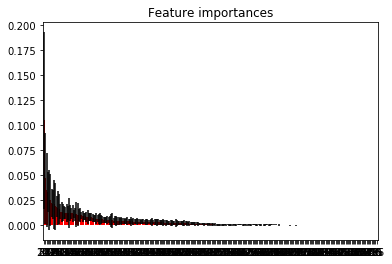

1. feature 33 (0.104534)
2. feature 247 (0.046676)
3. feature 101 (0.035090)
4. feature 242 (0.033077)
5. feature 110 (0.025223)
6. feature 11 (0.025204)
7. feature 107 (0.022295)
8. feature 74 (0.020907)
9. feature 95 (0.020635)
10. feature 80 (0.018854)
...


In [26]:
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

import matplotlib.pyplot as plt
from numpy import std, argsort

importances = random_forest._clf.feature_importances_
std = std([tree.feature_importances_ for tree in random_forest._clf.estimators_],
             axis=0)
indices = argsort(importances)[::-1]

num_features = len(random_forest._clf.feature_importances_)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(num_features), indices)
plt.xlim([-1, num_features])
plt.show()

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
print('...')

#### Scikit Learn metrics: Confusion matrix, Classification report, F1 score, Log loss

http://scikit-learn.org/stable/modules/model_evaluation.html

In [27]:
from sklearn import metrics

def classification_report(predict):
    predictions, labels = zip(*predict)
    return metrics.classification_report(labels, [p.max() for p in predictions])

def confusion_matrix(predict, print_layout=False):
    predictions, labels = zip(*predict)
    if print_layout is True:
        print('Layout\n[[tn   fp]\n [fn   tp]]\n')
    return metrics.confusion_matrix(labels, [p.max() for p in predictions])
    
def log_loss(predict):
    predictions, labels = zip(*predict)
    return metrics.log_loss(labels, [p.prob('pos') for p in predictions])

def roc_auc_score(predict):
    predictions, labels = zip(*predict)
    # need to convert labels to binary classification of 0 or 1
    return metrics.roc_auc_score([1 if l == 'pos' else 0 for l in labels], [p.prob('pos') for p in predictions], average='weighted')

def precision_recall_curve(predict):
    predictions, labels = zip(*predict)
    return metrics.precision_recall_curve(labels, [p.prob('pos') for p in predictions], pos_label='pos')

def average_precision_score(predict):
    predictions, labels = zip(*predict)
    return metrics.average_precision_score([1 if l == 'pos' else 0 for l in labels], [p.prob('pos') for p in predictions])

def roc_curve(predict):
    predictions, labels = zip(*predict)
    return metrics.roc_curve(labels, [p.prob('pos') for p in predictions], pos_label='pos')

In [28]:
print('SGD')
print(classification_report(sgd_predict))
print()
print('Logistic Regression')
print(classification_report(lr_predict))
print()
print('LinearSVC')
print(classification_report(linear_svc_predict))
print()
print('Random Forest')
print(classification_report(rf_predict))
print()
print('Voting')
print(classification_report(voting_predict))

SGD
             precision    recall  f1-score   support

        neg       0.91      0.76      0.83       480
        pos       0.78      0.91      0.84       437

avg / total       0.85      0.84      0.83       917


Logistic Regression
             precision    recall  f1-score   support

        neg       0.90      0.77      0.83       480
        pos       0.78      0.91      0.84       437

avg / total       0.85      0.84      0.84       917


LinearSVC
             precision    recall  f1-score   support

        neg       0.91      0.77      0.83       480
        pos       0.78      0.91      0.84       437

avg / total       0.85      0.84      0.84       917


Random Forest
             precision    recall  f1-score   support

        neg       0.87      0.78      0.82       480
        pos       0.78      0.87      0.83       437

avg / total       0.83      0.82      0.82       917


Voting
             precision    recall  f1-score   support

        neg       0.91     

In [29]:
print('Layout\n[[tn   fp]\n [fn   tp]]\n')

print('SGD')
print(confusion_matrix(sgd_predict))
print()
print('Logistic Regression')
print(confusion_matrix(lr_predict))
print()
print('LinearSVC')
print(confusion_matrix(linear_svc_predict))
print()
print('Random Forest')
print(confusion_matrix(rf_predict))
print()
print('Voting')
print(confusion_matrix(voting_predict))

Layout
[[tn   fp]
 [fn   tp]]

SGD
[[367 113]
 [ 38 399]]

Logistic Regression
[[370 110]
 [ 39 398]]

LinearSVC
[[368 112]
 [ 38 399]]

Random Forest
[[373 107]
 [ 55 382]]

Voting
[[372 108]
 [ 39 398]]


The lower the better for `log_loss`...

In [30]:
print(f'SGD: {log_loss(sgd_predict)}')
print(f'Logistic Regression: {log_loss(lr_predict)}')
print(f'LinearSVC: {log_loss(linear_svc_predict)}')
print(f'Random Forest: {log_loss(rf_predict)}')
print(f'Voting: {log_loss(voting_predict)}')

SGD: 0.3602928516558063
Logistic Regression: 0.3576544666544726
LinearSVC: 0.3587913221723783
Random Forest: 0.4359850133656391
Voting: 0.3440107245294793


The higher the better for `roc_auc_score`...

In [31]:
print(f'SGD: {roc_auc_score(sgd_predict)}')
print(f'Logistic Regression: {roc_auc_score(lr_predict)}')
print(f'LinearSVC: {roc_auc_score(linear_svc_predict)}')
print(f'Random Forest: {roc_auc_score(rf_predict)}')
print(f'Voting: {roc_auc_score(voting_predict)}')

SGD: 0.9245518688024409
Logistic Regression: 0.9241228070175438
LinearSVC: 0.9257389397406559
Random Forest: 0.9106097444698704
Voting: 0.9316266209000762


#### Performance on sample tasks

In [32]:
sample_tasks = ["Mow lawn", "Mow the lawn", "Buy new shoes", "Feed the dog", "Send report to Kyle", "Send the report to Kyle", "Peel the potatoes"]
features = [featurize(nlp(task)) for task in sample_tasks]

tasks_dummy = [(l, p.prob('pos')*1.0) for l, p in zip(dummy.classify_many(features), dummy.prob_classify_many(features))]
tasks_logistic = [(l, p.prob('pos')) for l,p in zip(logistic_regression.classify_many(features), logistic_regression.prob_classify_many(features))]
tasks_linear_svc = [(l, p.prob('pos')) for l,p in zip(linear_svc.classify_many(features), linear_svc.prob_classify_many(features))]
tasks_sgd = [(l, p.prob('pos')) for l,p in zip(sgd.classify_many(features), sgd.prob_classify_many(features))]
tasks_rf = [(l, p.prob('pos')) for l,p in zip(random_forest.classify_many(features), random_forest.prob_classify_many(features))]
tasks_voting = [(l, p.prob('pos')) for l,p in zip(voting.classify_many(features), voting.prob_classify_many(features))]

print(f'Dummy: {tasks_dummy}')
print(f'LogisticRegression: {tasks_logistic}')
print(f'LinearSVC: {tasks_linear_svc}')
print(f'SGD: {tasks_sgd}')
print(f'Random Forest: {tasks_rf}')
print()
print(f'Voting: {tasks_voting}')

Dummy: [('neg', 0.0), ('neg', 0.0), ('neg', 0.0), ('neg', 0.0), ('pos', 1.0), ('neg', 0.0), ('pos', 1.0)]
LogisticRegression: [('pos', 0.60220072135890279), ('pos', 0.75878324826920851), ('pos', 0.93270240152896788), ('pos', 0.75878324826920851), ('pos', 0.8530923605698969), ('pos', 0.75878324826920851), ('pos', 0.82376415483360399)]
LinearSVC: [('pos', 0.60233895420655026), ('pos', 0.73213333246004275), ('pos', 0.90283543907030761), ('pos', 0.73213333246004275), ('pos', 0.83325600977805936), ('pos', 0.73213333246004275), ('pos', 0.7794113091492908)]
SGD: [('pos', 0.60132912998097465), ('pos', 0.77418619826365875), ('pos', 0.94996303448610486), ('pos', 0.77418619826365875), ('pos', 0.89203930157365752), ('pos', 0.77418619826365875), ('pos', 0.84201090043390248)]
Random Forest: [('pos', 0.55593879812347236), ('pos', 0.83079704227680562), ('pos', 0.79803072527460683), ('pos', 0.83079704227680562), ('pos', 0.90433333333333321), ('pos', 0.83079704227680562), ('pos', 0.83484852349181149)]



#### Voting Model: Curves

Use the precision-recall curve and ROC to adjust the `pos`/`neg` threshold.

The threshold defaults to 0.5, meaning a probability >0.5 of being `pos` will result in a `pos` classification.

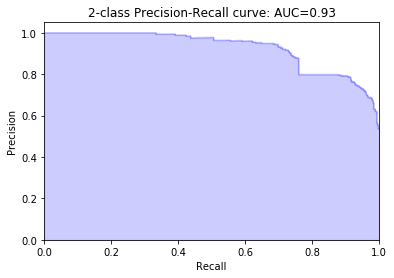

In [33]:
precision, recall, prc_thresholds = precision_recall_curve(voting_predict)
average_precision = average_precision_score(voting_predict)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
          average_precision))
plt.show()

Find a `Threshold` before `Precision` drops below 0.8.

In [34]:
from pandas import DataFrame

prt_df = DataFrame.from_records(list(zip(precision, recall, prc_thresholds)), columns = ['Precision', 'Recall', 'Threshold'])
prt_df.loc[(prt_df.Recall > 0.7) & (prt_df.Precision > 0.87)]

,Precision,Recall,Threshold
322,0.878307,0.759725,0.597657
323,0.877984,0.757437,0.605357
324,0.877660,0.755149,0.618050
325,0.880000,0.755149,0.627285
326,0.879679,0.752860,0.628034
327,0.879357,0.750572,0.628471
328,0.881720,0.750572,0.629713
329,0.881402,0.748284,0.630727
330,0.883784,0.748284,0.631524
331,0.883469,0.745995,0.638043


Let's pick a `Threshold` of 0.64.

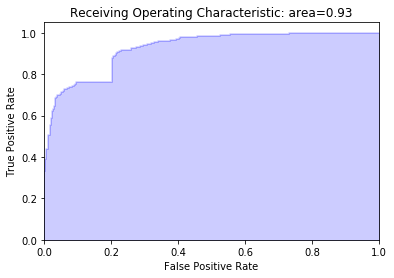

In [35]:
fpr, tpr, roc_thresholds = roc_curve(voting_predict)
area = roc_auc_score(voting_predict)

plt.figure()
plt.step(fpr, tpr, color='b', alpha=0.2,
         where='post')
plt.fill_between(fpr, tpr, step='post', alpha=0.2,
                 color='b')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Receiving Operating Characteristic: area={0:0.2f}'.format(
          area))
plt.show()

Find a `Threshold` around where `True Positive Rate` quickly goes above 0.8.

In [36]:
roc_df = DataFrame.from_records(list(zip(fpr, tpr, roc_thresholds)), columns = ['FPR', 'TPR', 'Threshold'])
roc_df.loc[(roc_df.FPR < 0.22) & (roc_df.TPR > 0.7)]

,FPR,TPR,Threshold
58,0.045833,0.704805,0.749972
59,0.050000,0.704805,0.745869
60,0.050000,0.711670,0.741134
61,0.056250,0.711670,0.735150
62,0.056250,0.720824,0.725225
63,0.060417,0.720824,0.705841
64,0.060417,0.727689,0.699777
65,0.062500,0.727689,0.691510
66,0.062500,0.729977,0.689967
67,0.066667,0.729977,0.684624


From this, a `Threshold` of ~0.596368 might be best for minimizing FPR and maximizing TPR (?).

Might be a bad idea to actualy adjust `Threshold`, a form of overfitting on the test set: https://stackoverflow.com/questions/32627926/scikit-changing-the-threshold-to-create-multiple-confusion-matrixes (although using ROC to do this might be ok? https://stackoverflow.com/a/35300649)

## Next Steps and Improvements

1. Training set may be too specific/not relevant enough (recipe instructions for positive dataset, recipe descriptions+short movie reviews for negative dataset)
2. Throwing features into a blender - need to understand value of each
    - What feature "classes" tend to perform the best/worst?
    - [PCA](http://jotterbach.github.io/2016/03/24/Principal_Component_Analysis/): Reducing dimensionality using most informative feature information
3. Phrase vectorizations of all 0s - how problematic is this?
4. Varying feature vector lengths - does this matter?
5. Voting - POS taggers
    - [SciKit Learn: Ensembles](http://scikit-learn.org/stable/modules/ensemble.html)
    - [Kaggle Ensembling Guide](https://mlwave.com/kaggle-ensembling-guide/)
6. Combining verb phrases
7. Cross validation, grid search
8. Look at examples from different quadrants of the confusion matrix - is there something we can learn?
    - Same idea with the classification report

---
# Things abandoned

## NLTK

I needed a library that supports dependency parsing, which NLTK does not... so I thought I'd add the [Stanford CoreNLP](https://stanfordnlp.github.io/CoreNLP/) toolkit and [its associated software](https://nlp.stanford.edu/software/) to NLTK. However, there are many conflicting instructions for installing the Java-based project, depending on NLTK version used. By the time I figured this out, the installation had become a time sink. So I abandoned this effort in favor of Spacy.io.

I might return this way if I want to improve results/implement a voter system between the various linguistic and classification methods later.

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

### Tokenization

In [ ]:
sentences = [s for l in lines for s in sent_tokenize(l)] # punkt
sentences

In [ ]:
tagged_sentences = []
for s in sentences:
    words = word_tokenize(s)
    tagged = nltk.pos_tag(words) # averaged_perceptron_tagger
    tagged_sentences.append(tagged)
print(tagged_sentences)

#### Note: POS accuracy

`Run down to the shop, will you, Peter` is parsed unexpectedly by `nltk.pos_tag`:
> `[('Run', 'NNP'), ('down', 'RB'), ('to', 'TO'), ('the', 'DT'), ('shop', 'NN'), (',', ','), ('will', 'MD'), ('you', 'PRP'), (',', ','), ('Peter', 'NNP')]`

`Run` is tagged as a `NNP (proper noun, singular)`

I expected an output more like what the [Stanford Parser](http://nlp.stanford.edu:8080/parser/) provides:
> `Run/VBG down/RP to/TO the/DT shop/NN ,/, will/MD you/PRP ,/, Peter/NNP`

`Run` is tagged as a `VGB (verb, gerund/present participle)` - still not quite the `VB` I want, but at least it's a `V*`

_MEANWHILE..._

`nltk.pos_tag` did better with:
> `[('Do', 'VB'), ('not', 'RB'), ('clean', 'VB'), ('soot', 'NN'), ('off', 'IN'), ('the', 'DT'), ('window', 'NN')]`

Compared to [Stanford CoreNLP](http://nlp.stanford.edu:8080/corenlp/process) (note that this is different than what [Stanford Parser](http://nlp.stanford.edu:8080/parser/) outputs):
> `(ROOT (S (VP (VB Do) (NP (RB not) (JJ clean) (NN soot)) (PP (IN off) (NP (DT the) (NN window))))))`

Concern: _clean_ as `VB (verb, base form)` vs `JJ (adjective)` 

**IMPROVE** POS taggers should vote: nltk.pos_tag (averaged_perceptron_tagger), Stanford Parser, CoreNLP, etc.

Note what Spacy POS tagger did with `Run down to the shop, will you Peter`:

`Run/VB down/RP to/IN the shop/NN ,/, will/MD you/PRP ,/, Peter/NNP`

    where `Run` is the `VB` I expected from POS tagging (compared to `nltk.pos_tag` result of `NNP`). Also note that Spacy collapses `the shop` into a single unit, which should be helpful during featurization.

### Featurization

In [ ]:
import re
from collections import defaultdict

featuresets = []
for ts in tagged_sentences:
    s_features = defaultdict(int)
    for idx, tup in enumerate(ts):
        #print(tup)
        pos = tup[1]
        # FeatureName.VERB
        is_verb = re.match(r'VB.?', pos) is not None
        print(tup, is_verb)
        if is_verb:
            s_features[FeatureName.VERB] += 1
            # FOLLOWING_POS
            next_idx = idx + 1;
            if next_idx < len(ts):
                s_features[f'{FeatureName.FOLLOWING}_{ts[next_idx][1]}'] += 1
            # VERB_MODIFIER
            # VERB_MODIFYING
        else:
            s_features[FeatureName.VERB] = 0
    featuresets.append(dict(s_features))

print()
print(featuresets)

### [Stanford NLP](https://nlp.stanford.edu/software/)
Setup guide used: https://stackoverflow.com/a/34112695

In [ ]:
# Get dependency parser, NER, POS tagger
!wget https://nlp.stanford.edu/software/stanford-parser-full-2017-06-09.zip
!wget https://nlp.stanford.edu/software/stanford-ner-2017-06-09.zip
!wget https://nlp.stanford.edu/software/stanford-postagger-full-2017-06-09.zip
!unzip stanford-parser-full-2017-06-09.zip
!unzip stanford-ner-2017-06-09.zip
!unzip stanford-postagger-full-2017-06-09.zip

In [ ]:
from nltk.parse.stanford import StanfordParser
from nltk.parse.stanford import StanfordDependencyParser
from nltk.parse.stanford import StanfordNeuralDependencyParser
from nltk.tag.stanford import StanfordPOSTagger, StanfordNERTagger
from nltk.tokenize.stanford import StanfordTokenizer